# England 2020-2021

In [123]:
import pandas as pd
import numpy as np

# Note: requires installation of odfpy and feather-format


## Community Life Survey

In [124]:
# Read loneliness sheet of community life survey for 2020/21
df = pd.read_excel("cls.ods",  engine="odf", sheet_name = "A6", skiprows = 26, nrows =1)

In [125]:
df.drop(columns=df.columns[:3], axis=1, inplace=True)

In [126]:
df = (df.T).reset_index()
df.rename(columns = {"index": "oac_11", 0: "perc" }, inplace = True)
df.drop(index=df.index[-1],axis=0,inplace=True)

In [127]:
df['oac_11'] = df.oac_11.str[-2:]

In [128]:
# Replace no value with 0
df.loc[19, 'perc'] = 0

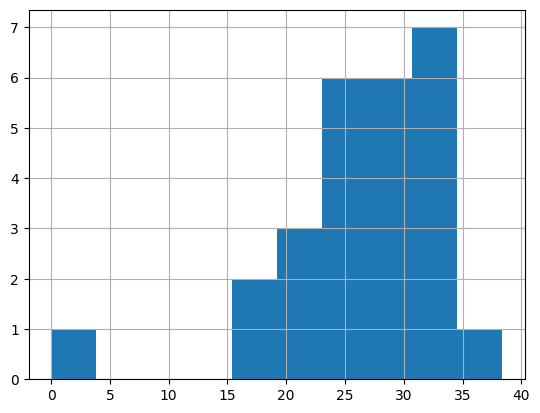

In [129]:
df.perc.hist();

## Join OAC to OA

In [130]:
# Read csv to join OAC to OA
oa = pd.read_csv("oac_lookup.csv")
oa = oa[["Output Area Code", "Group Code"]]
oa.rename(columns = {"Group Code": "oac_11", "Output Area Code":"oa11_code"}, inplace = True )

In [131]:
# Join to loneliness perc
df_oa = oa.merge(df, on = 'oac_11', how = 'left')

In [132]:
oa.oa11_code.nunique() == df_oa.oa11_code.nunique()

True

## Join OA11 to LSOA 11

In [133]:
# Read file from geographr to join OA 11 to LSOA 11
lookup_11 = pd.read_feather("../../extdata/lookup_11.feather")
lookup_11 = lookup_11[['lsoa11_code','oa11_code']]
df_lsoa11 = lookup_11.merge(df_oa, on = 'oa11_code', how = 'left')

In [134]:
# Drop NAs as not all LSOAs in lookup_11 are in England
df_lsoa11['perc'].dropna(inplace = True)

In [135]:
# Get average of each LSOA
df_lsoa11.perc = df_lsoa11.perc.astype(float)
df_lsoa11 = df_lsoa11.groupby(['lsoa11_code'], as_index = False)['perc'].mean()

In [136]:
df_lsoa11.lsoa11_code.nunique() == lookup_11.lsoa11_code.nunique()

True

## Join LSOA 11 to LSOA 21

In [139]:
# Read file from geographr to join lsoa 11 code to lsoa 21 code 
lookup_21 = pd.read_feather("../../extdata/lookup_21.feather")
lookup_21 = lookup_21[["lsoa11_code", "lsoa21_code"]]
loneliness = df_lsoa11.merge(lookup_21, on = "lsoa11_code", how = "left")

In [140]:
loneliness = loneliness[["lsoa21_code", "perc"]]

In [142]:
loneliness = loneliness.groupby("lsoa21_code", as_index = False).mean()

In [143]:
loneliness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lsoa21_code  35672 non-null  object 
 1   perc         35672 non-null  float64
dtypes: float64(1), object(1)
memory usage: 557.5+ KB


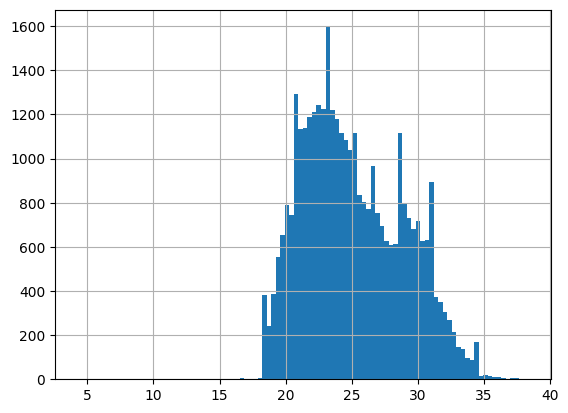

In [144]:
loneliness.perc.hist(bins = 100);

In [145]:
lookup_21['lsoa21_code'].nunique() == loneliness.lsoa21_code.nunique()

True

In [154]:
loneliness.sample(5)

,lsoa21_code,perc
7412,E01007788,21.545560
31086,E01032781,31.663336
31064,E01032745,30.471473
11314,E01011901,27.409672
15470,E01016289,19.570296


In [155]:
loneliness.to_csv("../../extdata/england_cls_2020_2021.csv", index = False )